## Prueba con capa semantica

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from myGenerator import DataGenerator

### Carga de datos

In [2]:
train = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTrain.plk")
val = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanVal.plk")

In [3]:
def spectraLoader(inputPath: str) -> pd.DataFrame:
    df = pd.DataFrame()
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            lineDf = pd.DataFrame({'id':jsonline['id'], 'spectra':[np.array(jsonline['spectra'])]})
            df = pd.concat([df, lineDf])
    df = df.reset_index(drop=True)

    return df

In [4]:
full_spectra = spectraLoader("pan22-authorship-verification-training-dataset/particionesXid/FullSpectra.jsonl")

In [5]:
def loadLabels(inputPath:str, labelDict:dict) -> dict:
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            labelDict[jsonline['id']] = 1 if jsonline['value'] else 0
        
    return labelDict

In [6]:
labels = dict()
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/train_truth.jsonl',labels)
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/val_truth.jsonl',labels)

In [7]:
print("Instances: {}".format((train.shape[0] + val.shape[0])/2))
print("Labels: ",len(labels))

Instances: 16486.0
Labels:  16486


In [8]:
partition = {'train': train.id.unique().tolist(), 'validation': val.id.unique().tolist()}

In [9]:
print("Train: ", len(partition['train']))
print("Validation: ", len(partition['validation']))
print("Total: ", len(partition['train'])+len(partition['validation']))

Train:  15732
Validation:  754
Total:  16486


### Definición de la arquitectura del modelo

In [10]:
# Modelo de red siamesa utilizando una red residual y un perceptron multicapa SIN CAPAS CUSTOM

def setModel():
    x1 = tf.keras.Input(shape=(400,), name="input_1")
    x2 = tf.keras.Input(shape=(400,), name="input_2")

    merge = x1-x2

    # MLPNN Classifier
    hidden1 = tf.keras.layers.Dense(600, activation='relu',kernel_regularizer='l2' , name="HiddenLayer1")(merge)
    dropout_layer1 = tf.keras.layers.Dropout(0.4, name="Dropout1")(hidden1)
    hidden2 = tf.keras.layers.Dense(300, activation='relu',kernel_regularizer='l2' , name="HiddenLayer2")(dropout_layer1)
    dropout_layer2 = tf.keras.layers.Dropout(0.4, name="Dropout2")(hidden2)
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(dropout_layer2)

    model = tf.keras.Model([x1, x2], output)
    model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["binary_accuracy"])

    return model

In [11]:
model = setModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 400)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 HiddenLayer1 (Dense)           (None, 600)          240600      ['tf.math.subtract[0][0]']   

2022-05-26 17:27:34.861650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 17:27:34.883816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 17:27:34.883974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 17:27:34.884502: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Entrenamiento del modelo

In [12]:
# Parameters
params = {'dim': (400,),
            'batch_size': 256,
            'shuffle': True}

In [13]:
# Generators
training_generator = DataGenerator(partition['train'], train, labels, full_spectra, **params)
validation_generator = DataGenerator(partition['validation'], val, labels, full_spectra, **params)

In [14]:
tf.test.gpu_device_name()

2022-05-26 17:27:35.456238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


'/device:GPU:0'

2022-05-26 17:27:35.456512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 17:27:35.457138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 17:27:35.457314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 17:27:35.457411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 17:27:35.457485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 7

In [15]:
# Train model on dataset
with tf.device('/device:GPU:0'):
    model = setModel()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    history = model.fit(x=training_generator,
                        validation_data=validation_generator,
                        callbacks=[callback],
                        # use_multiprocessing=True,
                        # workers=4,
                        epochs=100,
                        verbose=1)
print("Entrnamiento completado")

Epoch 1/100
 1/61 [..............................] - ETA: 1:25 - loss: 9.4809 - binary_accuracy: 0.5469

2022-05-26 17:27:37.485150: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


61/61 [==============================] - 27s 427ms/step - loss: 3.8374 - binary_accuracy: 0.5477 - val_loss: 1.1236 - val_binary_accuracy: 0.5664
Epoch 2/100
61/61 [==============================] - 27s 434ms/step - loss: 0.8030 - binary_accuracy: 0.5298 - val_loss: 0.6984 - val_binary_accuracy: 0.5039
Epoch 3/100
61/61 [==============================] - 26s 432ms/step - loss: 0.6944 - binary_accuracy: 0.5077 - val_loss: 0.6942 - val_binary_accuracy: 0.4902
Epoch 4/100
61/61 [==============================] - 26s 429ms/step - loss: 0.6936 - binary_accuracy: 0.5069 - val_loss: 0.6932 - val_binary_accuracy: 0.5195
Epoch 5/100
61/61 [==============================] - 26s 430ms/step - loss: 0.6934 - binary_accuracy: 0.5041 - val_loss: 0.6935 - val_binary_accuracy: 0.4980
Epoch 6/100
61/61 [==============================] - 26s 431ms/step - loss: 0.6932 - binary_accuracy: 0.5051 - val_loss: 0.6934 - val_binary_accuracy: 0.4902
Epoch 7/100
61/61 [==============================] - 27s 437ms/s

In [16]:
model.save('models/ClassifierModel-v20')

2022-05-26 17:32:27.397470: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/ClassifierModel-v20/assets


### Resultados del entrenamiento

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [18]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [19]:
acc = pd.DataFrame({'accuracy':history.history['binary_accuracy'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
acc = pd.concat([acc, pd.DataFrame({'accuracy':history.history['val_binary_accuracy'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)
loss = pd.DataFrame({'loss':history.history['loss'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
loss = pd.concat([loss, pd.DataFrame({'loss':history.history['val_loss'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)

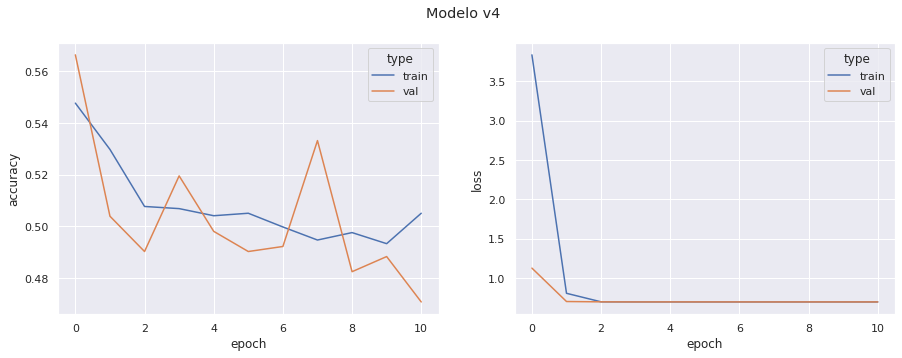

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x='epoch', y='accuracy', data=acc, hue='type', ax=ax[0])
sns.lineplot(x='epoch', y='loss', data=loss, hue='type', ax=ax[1])
fig.suptitle("Modelo v4")
plt.show()

In [21]:
acc.loc[acc.epoch == acc.epoch.max()]

,epoch,accuracy,type
10,10,0.505059,train
21,10,0.470703,val


In [22]:
loss.loc[loss.epoch == loss.epoch.max()]

,epoch,loss,type
10,10,0.693274,train
21,10,0.693176,val


### Evaluación de datos de prueba

In [1]:
!python PredictionsTest.py -i testinput -o testoutput/v20

[nltk_data] Downloading package punkt to /home/melesio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/melesio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/melesio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/melesio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/melesio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Leyendo archivo de configuracion
Inicia la transformacion de texto
Creando diccionario de documentos unicos
Realizando preprocesamiento
Etapa de pre-procesmiento
Extrayendo vectores de caracteristicas
Etapa de extraccion de caracteristicas
Extraccion de vectores lexicos
Realizando vectorizacion


In [2]:
!python pan22_verif_evaluator.py -i testinput -a testoutput/v20 -o testoutput/v20

-> 1070 problems in ground truth
-> 1070 solutions explicitly proposed
{'auc': 0.493, 'c@1': 0.503, 'f_05_u': 0.557, 'F1': 0.668, 'brier': 0.75, 'overall': 0.594}
